## Personalized Learning (Localized Learning?)

#### This notebook includes the following online models;
1. A single global model with all data
2. Multiple local models (starting from a single global model)
   1. that are updated with new data
   2. that exchanges data in clusters
   3. that exchanges parameters in clusters

  
#### The dataset that is used for this project is [CIFAR-100 dataset][1]
* Has 100 classes containing 600 images each

#### New data are fed by the following rules;
1. Distributed, according to superclasses
  * Clusters will only be updated with data that belongs to a specific superclass
  * We update the NN by
    1. Changing all parameters of the NN
    2. Only changing the last few layers, as in many MTL models
2. Randomly (why?)

#### We expect to find an answer to the following research questions with this project;
1. If models are updated with data (or parameters) that are shared within a cluster, can the model perform good enough with the labels that count?
  * For example, the performance of the cluster that are updated with "Vehicles" superclass is only assessed with the labels that corresponds to the superclass.
  
[1]: https://www.cs.toronto.edu/~kriz/cifar.html

#### Questions

Retraining: how does it work <br>
How do we compare these models?


### Implementation with Custom Neural Network and EMNIST dataset

In [1]:
%load_ext tensorboard

In [2]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [3]:
import matplotlib
import copy

In [4]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines

In [36]:
import semantic_drift

In [5]:
import tensorflow as tf
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [6]:
tf.__version__

'1.15.2'

In [7]:
# Hyperparameters
batch_size = 50
epochs = 20

# input image dimensions
img_rows, img_cols = 28, 28

#### Load MNIST dataset

In [8]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test_orig) = mnist.load_data()

In [9]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [10]:
x_train.shape

(60000, 28, 28, 1)

In [11]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [12]:
global_dataset_size = 6000
local_dataset_size = 40000

In [13]:
import utils

In [14]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/seth/projects/fed-learn-experiment/utils.py'>

In [15]:
TRAIN_DATA_SIZE = 1000

In [16]:
# convert class vectors to binary class matrices
num_classes = 10


In [17]:
y_test = keras.utils.to_categorical(y_test_orig, num_classes)

### Define models and compile & fit function

In [18]:
def custom_model():
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [19]:
def compile_model(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=0.1)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [20]:
def compile_model_lr(model):  
    # initiate SGD optimizer
    opt = keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])

In [21]:
def fit_model_global(model, epochs):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(X_global, Y_global,
                      batch_size=100,
                      epochs=40,
                      shuffle=True, callbacks=[tensorboard_callback])

In [22]:
def fit_model_with_datasets(model, epochs, x_train, y_train):
    now = datetime.datetime.now()
    print ("Training date and time : ")
    print (now.strftime("%Y-%m-%d %H:%M:%S"))
    return model.fit(x_train, y_train,
                      batch_size=50,
                      epochs=epochs,
                      shuffle=True, verbose=1)

In [23]:
def add_hist_to_dict(d, hist):
    if 'loss' not in d:
        d['loss'] = hist[0]
    else:
        d['loss'] = np.append(d['loss'], hist[0])
    if 'acc' not in d:
        d['acc'] = hist[1]
    else:
        d['acc'] = np.append(d['acc'], hist[1])

### Check in what epoch the model starts to overfit for all labels.
The paper said 20. 

In [30]:
x04, y04 = utils.filter_data_by_labels(x_train, y_train, np.arange(10), 600, 1, 1000)
yt = keras.utils.to_categorical(y_test_orig, 10)
y04 = keras.utils.to_categorical(y04, 10)
test_model = custom_model()
compile_model(test_model)
train_loss = []
test_loss = []
for e in range(60):
    print("-------epoch: {}---------".format(e))
    hist = fit_model_with_datasets(test_model, 1, x04, y04)
    res = test_model.evaluate(x=x_test, y=yt, verbose=0)
    train_loss.append(hist.history['loss'])
    test_loss.append(res[0])
    print(res)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
-------epoch: 0---------
Training date and time : 
2020-09-14 17:36:34
Train on 600 samples
600/600 [==============================] - 0s 543us/sample - loss: 0.0905 - acc: 0.1033
[0.09046416474580765, 0.1091]
-------epoch: 1---------
Training date and time : 
2020-09-14 17:36:36
Train on 600 samples
600/600 [==============================] - 0s 35us/sample - loss: 0.0902 - acc: 0.1250
[0.09016787046194076, 0.125]
-------epoch: 2---------
Training date and time : 
2020-09-14 17:36:36
Train on 600 samples
600/600 [==============================] - 0s 30us/sample - loss: 0.0898 - acc: 0.1483
[0.08986922863721848, 0.1432]
-------epoch: 3---------
Training date and time : 
2020-09-14 17:36:36
Train on 600 samples
600/600 [==============================] - 0s 34us/sample - loss: 0.0895 - acc: 0.1667
[0.08956816148757935, 0.1585]
-------epoch: 4---------
Training date and time : 
2020-09-14 17:36:37
Train on 600

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (60,) and (11, 1)

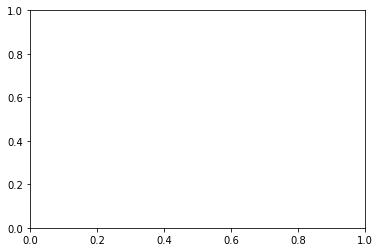

In [31]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(60)+1, train_loss)
plt.plot(np.arange(60)+1, test_loss)
plt.title("loss of an aggregated model - loss of an original 0to4 model")
plt.ylabel("loss")
plt.xlabel("<-- (non-iid)   noise ratio   (iid) --->")
plt.show()

### Check in what epoch the model starts to overfit for labels 0 ~ 4.
I think it's 20 again

In [ ]:
x04, y04 = utils.filter_data_by_labels(x_train, y_train, np.arange(5), 600, 1, 1000)
xt04, yt04 = utils.filter_data_by_labels(x_test, y_test_orig, np.arange(5), 3000, 1, 1000)
yt04 = keras.utils.to_categorical(yt04, 10)
y04 = keras.utils.to_categorical(y04, 10)
test_model = custom_model()
compile_model(test_model)
train_loss = []
test_loss = []
for e in range(60):
    print("-------epoch: {}---------".format(e))
    hist = fit_model_with_datasets(test_model, 1, x04, y04)
    res = test_model.evaluate(x=xt04, y=yt04, verbose=0)
    train_loss.append(hist.history['loss'])
    test_loss.append(res[0])
    print(res)

In [ ]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(60)+1, train_loss)
plt.plot(np.arange(60)+1, test_loss)
plt.title("loss of an aggregated model - loss of an original 0to4 model")
plt.ylabel("loss")
plt.xlabel("<-- (non-iid)   noise ratio   (iid) --->")
plt.show()

In [ ]:
np.bincount(y2)

In [61]:
def get_losses_for_overlapping_labels(model, epochs, x_train, y_train, x_test, y_test, size, diff):
    """
    only overlap label 4
    """
    num_total_classes = 10 # todo np.unique(y_train)
    
    res = {}
    res['model_aggr'] = {}
    res['model_0to4'] = {}
    res['model_5to9'] = {}
    res['model_aggr']['test_all'] = {}
    res['model_aggr']['test_0to4'] = {}
    res['model_aggr']['test_5to9'] = {}
    res['model_aggr']['test_0'] = {}
    
    
    res['model_0to4'] = copy.deepcopy(res['model_aggr'])
    res['model_5to9'] = copy.deepcopy(res['model_aggr'])
    
    additionals = {}
    additionals['l2_dist'] = []
    additionals['req_rounds'] = []
    
    y_test_one_hot = keras.utils.to_categorical(y_test, num_total_classes)
    tx1, ty1 = utils.filter_data_by_labels(x_test, y_test, np.arange(5), 1000)
    tx2, ty2 = utils.filter_data_by_labels(x_test, y_test, np.arange(5)+5, 1000)
    tx0, ty0 = utils.filter_data_by_labels(x_test, y_test, np.arange(1), 200)
    
    ty1 = keras.utils.to_categorical(ty1, num_total_classes)
    ty2 = keras.utils.to_categorical(ty2, num_total_classes)
    ty0 = keras.utils.to_categorical(ty0, num_total_classes)
    
    label_move = 2
    
    for r in np.arange(0, label_move, diff):
        print("--------------  Iteration #{}  --------------".format((int)(r/diff)))
        
        # get data
        randseed = (int)(np.random.rand(1)[0] * 1000) + 2
        x1, y1 = utils.filter_data_by_labels(x_train, y_train, np.arange(5), size, 0, randseed)
        
        label_conf = {}
        start_label = (int)(r)
        end_label = 4 + start_label
        for i in np.arange(0, start_label, 1):
            label_conf[i] = 0
        for i in np.arange(start_label, end_label+2, 1):
            if i == start_label:
                label_conf[i] = (int)(120 * (1-(r-start_label)))
            elif i == end_label+1:
                label_conf[i] = 120 - (label_conf[start_label])
            else:
                label_conf[i] = 120

        x2, y2 = utils.filter_data_by_labels_with_numbers(x_train, 
                                                          y_train, 
                                                          np.arange(end_label+2), 
                                                          label_conf,
                                                          randseed+1000)

        y1 = keras.utils.to_categorical(y1, num_total_classes)
        y2 = keras.utils.to_categorical(y2, num_total_classes)
        
        # initialize models
        model1 = keras.models.clone_model(model)
        model2 = keras.models.clone_model(model)
        model1.set_weights(model.get_weights())
        model2.set_weights(model.get_weights())
        compile_model(model1)
        compile_model(model2)
        
        # fit
        fit_model_with_datasets(model1, 20, x1, y1)
        fit_model_with_datasets(model2, 20, x2, y2)
        
        additionals['l2_dist'].append(semantic_drift.l2_distance(model1, model2))
        
        # test
        add_hist_to_dict(res['model_0to4']['test_all'],
                         model1.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_0to4'],
                         model1.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_5to9'],
                         model1.evaluate(x=tx2, y=ty2, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_0'],
                         model1.evaluate(x=tx0, y=ty0, verbose=0))
        
        add_hist_to_dict(res['model_5to9']['test_all'],
                         model2.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_0to4'],
                         model2.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_5to9'],
                         model2.evaluate(x=tx2, y=ty2, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_0'],
                         model2.evaluate(x=tx0, y=ty0, verbose=0))
        
        pre_eval_res = model1.evaluate(x=tx1, y=ty1, verbose=0)
        
        
        rounds = 100
        rounds_max = 15
        for ro in range(rounds):
            #aggregate
            weights = [model1.get_weights(), model2.get_weights()]
            agg_weights = list()
            theta = 0.5
            for weights_list_tuple in zip(*weights):
                agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
            aggr_model = keras.models.clone_model(model1)
            aggr_model.set_weights(agg_weights)
            compile_model(aggr_model)
            
            model1.set_weights(agg_weights)
            model2.set_weights(agg_weights)
            
            # stop criteria
            eval_res = aggr_model.evaluate(x=tx1, y=ty1, verbose=0)
            if eval_res[1] >= pre_eval_res[1] + 0.02:
                additionals['req_rounds'].append(ro)
                break;
            
            # exceeded max rounds
            if ro > rounds_max:
                additionals['req_rounds'].append(ro)
                break;
            
            # fit
            if ro < rounds:
                fit_model_with_datasets(model1, epochs, x1, y1)
                fit_model_with_datasets(model2, epochs, x2, y2)
        
        # test
        add_hist_to_dict(res['model_aggr']['test_all'],
                         aggr_model.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_0to4'],
                         aggr_model.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_5to9'],
                         aggr_model.evaluate(x=tx2, y=ty2, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_0'],
                         aggr_model.evaluate(x=tx0, y=ty0, verbose=0))
        
    return res, additionals

In [ ]:
def get_losses_for_overlapping_spectrum(model, epochs, x_train, y_train, x_test, y_test, size, diff):
    num_total_classes = 10 # todo np.unique(y_train)
    
    res = {}
    res['model_aggr'] = {}
    res['model_0to4'] = {}
    res['model_5to9'] = {}
    res['model_aggr']['test_all'] = {}
    res['model_aggr']['test_0to4'] = {}
    res['model_aggr']['test_5to9'] = {}
    
    res['model_0to4'] = copy.deepcopy(res['model_aggr'])
    res['model_5to9'] = copy.deepcopy(res['model_aggr'])
    
    y_test_one_hot = keras.utils.to_categorical(y_test, num_total_classes)
    tx1, ty1 = utils.filter_data_by_labels(x_test, y_test, np.arange(5), 1000)
    tx2, ty2 = utils.filter_data_by_labels(x_test, y_test, np.arange(5)+5, 1000)
    
    ty1 = keras.utils.to_categorical(ty1, num_total_classes)
    ty2 = keras.utils.to_categorical(ty2, num_total_classes)
    
    for r in np.arange(6):
        # get data
        randseed = (int)(np.random.rand(1)[0] * 1000) + 2
        x1, y1 = utils.filter_data_by_labels(x_train, y_train, np.arange(5), size, 0, randseed)
        x2, y2 = utils.filter_data_by_labels(x_train, y_train, np.arange(5)+r, size, 0, randseed+1000)

        y1 = keras.utils.to_categorical(y1, num_total_classes)
        y2 = keras.utils.to_categorical(y2, num_total_classes)
        
        # initialize models
        model1 = keras.models.clone_model(model)
        model2 = keras.models.clone_model(model)
        model1.set_weights(model.get_weights())
        model2.set_weights(model.get_weights())
        compile_model(model1)
        compile_model(model2)
        
        # fit
        fit_model_with_datasets(model1, epochs, x1, y1)
        fit_model_with_datasets(model2, epochs, x2, y2)
        
        #aggregate
        weights = [model1.get_weights(), model2.get_weights()]
        agg_weights = list()
        theta = 0.5
        for weights_list_tuple in zip(*weights):
            agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights)
        compile_model(aggr_model)
        
        # test
        add_hist_to_dict(res['model_0to4']['test_all'],
                         model1.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_0to4'],
                         model1.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_5to9'],
                         model1.evaluate(x=tx2, y=ty2, verbose=0))
        
        add_hist_to_dict(res['model_5to9']['test_all'],
                         model2.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_0to4'],
                         model2.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_5to9'],
                         model2.evaluate(x=tx2, y=ty2, verbose=0))
        
        add_hist_to_dict(res['model_aggr']['test_all'],
                         aggr_model.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_0to4'],
                         aggr_model.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_5to9'],
                         aggr_model.evaluate(x=tx2, y=ty2, verbose=0))
        
    return res

In [63]:
def multiple_experiments(func, num, params):
    shape = (len(np.arange(1, 0-params['diff'], -params['diff'])), 2)
    res_sum = {}
    start_time = datetime.datetime.now()
    additionals_sum = {}
    for n in range(num):
        print("------------- {}th experiment -------------".format(n))
        res, additionals = func(**params)
        
        for k in additionals:
            if k not in additionals_sum:
                additionals_sum[k] = copy.deepcopy(additionals[k])
            else:
                additionals_sum[k] += additionals[k]
        
        for k in res: # for(models)
            if k not in res_sum:
                res_sum[k] = copy.deepcopy(res[k])
            else:
                for l in res_sum[k]: # for(test sets)
                    for i in res_sum[k][l]: # for(metric)
                        res_sum[k][l][i] += res[k][l][i]
                    
    for k in res_sum:
        for l in res_sum[k]:
            for i in res_sum[k][l]:
                res_sum[k][l][i] /= num
    
    rem = (datetime.datetime.now() - start_time) / (n+1) * (num-n-1)
    print("remaining time: {}".format(now.strftime("%H:%M:%S")))
          
    return res_sum, additionals_sum

In [33]:
init_model = custom_model()

In [34]:
params = {'model': init_model,
          'epochs': 10,
          'x_train': x_train,
          'y_train': y_train,
          'x_test': x_test,
          'y_test': y_test_orig,
          'size': 600,
          'diff': 0.1}

In [ ]:
def get_mock_res(diff):
    mock_res = {}
    mock_res['model_aggr'] = {}
    mock_res['model_0to4'] = {}
    mock_res['model_5to9'] = {}
    
    loss = np.random.rand(2)
    acc = np.random.rand(2)
    mock_res['model_aggr']['test_all'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_0to4']['test_all'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_5to9']['test_all'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_aggr']['test_0to4'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_0to4']['test_0to4'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_5to9']['test_0to4'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_aggr']['test_5to9'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_0to4']['test_5to9'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    mock_res['model_5to9']['test_5to9'] = {'loss': copy.deepcopy(loss), 'acc': copy.deepcopy(acc)}
    
    return mock_res

In [54]:
res = get_losses_for_overlapping_labels(**params)

--------------  Iteration #0  --------------
Training date and time : 
2020-09-14 20:21:09
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.0898 - acc: 0.1733
Epoch 2/20
600/600 [==============================] - 0s 79us/sample - loss: 0.0882 - acc: 0.2200
Epoch 3/20
600/600 [==============================] - 0s 78us/sample - loss: 0.0866 - acc: 0.2750
Epoch 4/20
600/600 [==============================] - 0s 78us/sample - loss: 0.0849 - acc: 0.3383
Epoch 5/20
600/600 [==============================] - 0s 81us/sample - loss: 0.0831 - acc: 0.4233
Epoch 6/20
600/600 [==============================] - 0s 74us/sample - loss: 0.0811 - acc: 0.5433
Epoch 7/20
600/600 [==============================] - 0s 79us/sample - loss: 0.0788 - acc: 0.6350
Epoch 8/20
600/600 [==============================] - 0s 85us/sample - loss: 0.0762 - acc: 0.7100
Epoch 9/20
600/600 [==============================] - 0s 77us/sample - loss: 0.0732 - acc: 0.7450
Epoch 1

Epoch 20/20
600/600 [==============================] - 0s 72us/sample - loss: 0.0348 - acc: 0.8850
Training date and time : 
2020-09-14 20:22:17
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 1s 2ms/sample - loss: 0.0896 - acc: 0.1633
Epoch 2/20
600/600 [==============================] - 0s 83us/sample - loss: 0.0882 - acc: 0.2283
Epoch 3/20
600/600 [==============================] - 0s 70us/sample - loss: 0.0868 - acc: 0.2950
Epoch 4/20
600/600 [==============================] - 0s 76us/sample - loss: 0.0853 - acc: 0.3617
Epoch 5/20
600/600 [==============================] - 0s 82us/sample - loss: 0.0837 - acc: 0.4367
Epoch 6/20
600/600 [==============================] - 0s 85us/sample - loss: 0.0821 - acc: 0.5200
Epoch 7/20
600/600 [==============================] - 0s 72us/sample - loss: 0.0803 - acc: 0.5983
Epoch 8/20
600/600 [==============================] - 0s 81us/sample - loss: 0.0782 - acc: 0.6717
Epoch 9/20
600/600 [==============================]

602/602 [==============================] - 0s 76us/sample - loss: 0.0527 - acc: 0.8173
Epoch 18/20
602/602 [==============================] - 0s 69us/sample - loss: 0.0491 - acc: 0.8306
Epoch 19/20
602/602 [==============================] - 0s 75us/sample - loss: 0.0457 - acc: 0.8439
Epoch 20/20
602/602 [==============================] - 0s 78us/sample - loss: 0.0425 - acc: 0.8488
Training date and time : 
2020-09-14 20:25:04
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 73us/sample - loss: 0.0338 - acc: 0.9017
Epoch 2/10
600/600 [==============================] - 0s 81us/sample - loss: 0.0311 - acc: 0.9050
Epoch 3/10
600/600 [==============================] - 0s 64us/sample - loss: 0.0287 - acc: 0.9083
Epoch 4/10
600/600 [==============================] - 0s 77us/sample - loss: 0.0267 - acc: 0.9117
Epoch 5/10
600/600 [==============================] - 0s 78us/sample - loss: 0.0248 - acc: 0.9150
Epoch 6/10
600/600 [==============================] - 0s 70

600/600 [==============================] - 0s 74us/sample - loss: 0.0568 - acc: 0.8633
Epoch 15/20
600/600 [==============================] - 0s 75us/sample - loss: 0.0532 - acc: 0.8817
Epoch 16/20
600/600 [==============================] - 0s 80us/sample - loss: 0.0495 - acc: 0.9067
Epoch 17/20
600/600 [==============================] - 0s 77us/sample - loss: 0.0458 - acc: 0.9133
Epoch 18/20
600/600 [==============================] - 0s 72us/sample - loss: 0.0421 - acc: 0.9200
Epoch 19/20
600/600 [==============================] - 0s 78us/sample - loss: 0.0387 - acc: 0.9217
Epoch 20/20
600/600 [==============================] - 0s 80us/sample - loss: 0.0356 - acc: 0.9267
Training date and time : 
2020-09-14 20:27:43
Train on 601 samples
Epoch 1/20
601/601 [==============================] - 1s 2ms/sample - loss: 0.0894 - acc: 0.1747
Epoch 2/20
601/601 [==============================] - 0s 83us/sample - loss: 0.0879 - acc: 0.2413
Epoch 3/20
601/601 [==============================] - 0s 

600/600 [==============================] - 0s 72us/sample - loss: 0.0743 - acc: 0.6517
Epoch 12/20
600/600 [==============================] - 0s 79us/sample - loss: 0.0722 - acc: 0.6533
Epoch 13/20
600/600 [==============================] - 0s 69us/sample - loss: 0.0699 - acc: 0.6750
Epoch 14/20
600/600 [==============================] - 0s 85us/sample - loss: 0.0675 - acc: 0.6850
Epoch 15/20
600/600 [==============================] - 0s 77us/sample - loss: 0.0650 - acc: 0.7033
Epoch 16/20
600/600 [==============================] - 0s 88us/sample - loss: 0.0623 - acc: 0.7083
Epoch 17/20
600/600 [==============================] - 0s 75us/sample - loss: 0.0597 - acc: 0.7133
Epoch 18/20
600/600 [==============================] - 0s 82us/sample - loss: 0.0571 - acc: 0.7183
Epoch 19/20
600/600 [==============================] - 0s 73us/sample - loss: 0.0545 - acc: 0.7200
Epoch 20/20
600/600 [==============================] - 0s 73us/sample - loss: 0.0521 - acc: 0.7200
Training date and time

600/600 [==============================] - 0s 73us/sample - loss: 0.0797 - acc: 0.6250
Epoch 8/20
600/600 [==============================] - 0s 84us/sample - loss: 0.0774 - acc: 0.7217
Epoch 9/20
600/600 [==============================] - 0s 87us/sample - loss: 0.0747 - acc: 0.7683
Epoch 10/20
600/600 [==============================] - 0s 80us/sample - loss: 0.0717 - acc: 0.8100
Epoch 11/20
600/600 [==============================] - 0s 84us/sample - loss: 0.0683 - acc: 0.8283
Epoch 12/20
600/600 [==============================] - 0s 82us/sample - loss: 0.0649 - acc: 0.8333
Epoch 13/20
600/600 [==============================] - 0s 84us/sample - loss: 0.0614 - acc: 0.8517
Epoch 14/20
600/600 [==============================] - 0s 77us/sample - loss: 0.0578 - acc: 0.8550
Epoch 15/20
600/600 [==============================] - 0s 80us/sample - loss: 0.0542 - acc: 0.8767
Epoch 16/20
600/600 [==============================] - 0s 78us/sample - loss: 0.0505 - acc: 0.8917
Epoch 17/20
600/600 [===

600/600 [==============================] - 0s 76us/sample - loss: 0.0337 - acc: 0.9050
Epoch 5/10
600/600 [==============================] - 0s 77us/sample - loss: 0.0306 - acc: 0.9117
Epoch 6/10
600/600 [==============================] - 0s 76us/sample - loss: 0.0281 - acc: 0.9150
Epoch 7/10
600/600 [==============================] - 0s 85us/sample - loss: 0.0259 - acc: 0.9200
Epoch 8/10
600/600 [==============================] - 0s 76us/sample - loss: 0.0240 - acc: 0.9183
Epoch 9/10
600/600 [==============================] - 0s 83us/sample - loss: 0.0224 - acc: 0.9217
Epoch 10/10
600/600 [==============================] - 0s 74us/sample - loss: 0.0210 - acc: 0.9233
Training date and time : 
2020-09-14 20:35:35
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 72us/sample - loss: 0.0554 - acc: 0.6983
Epoch 2/10
600/600 [==============================] - 0s 78us/sample - loss: 0.0533 - acc: 0.7017
Epoch 3/10
600/600 [==============================] - 0s 74us

600/600 [==============================] - 0s 73us/sample - loss: 0.0469 - acc: 0.7583
Epoch 2/10
600/600 [==============================] - 0s 67us/sample - loss: 0.0401 - acc: 0.8567
Epoch 3/10
600/600 [==============================] - 0s 68us/sample - loss: 0.0348 - acc: 0.8933
Epoch 4/10
600/600 [==============================] - 0s 71us/sample - loss: 0.0313 - acc: 0.9067
Epoch 5/10
600/600 [==============================] - 0s 67us/sample - loss: 0.0286 - acc: 0.9117
Epoch 6/10
600/600 [==============================] - 0s 76us/sample - loss: 0.0263 - acc: 0.9133
Epoch 7/10
600/600 [==============================] - 0s 62us/sample - loss: 0.0244 - acc: 0.9133
Epoch 8/10
600/600 [==============================] - 0s 70us/sample - loss: 0.0228 - acc: 0.9133
Epoch 9/10
600/600 [==============================] - 0s 73us/sample - loss: 0.0214 - acc: 0.9200
Epoch 10/10
600/600 [==============================] - 0s 72us/sample - loss: 0.0202 - acc: 0.9167
Training date and time : 
2020

601/601 [==============================] - 0s 67us/sample - loss: 0.0322 - acc: 0.8336
Epoch 8/10
601/601 [==============================] - 0s 75us/sample - loss: 0.0313 - acc: 0.8419
Epoch 9/10
601/601 [==============================] - 0s 76us/sample - loss: 0.0303 - acc: 0.8403
Epoch 10/10
601/601 [==============================] - 0s 76us/sample - loss: 0.0295 - acc: 0.8502
Training date and time : 
2020-09-14 20:40:32
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 70us/sample - loss: 0.0195 - acc: 0.9133
Epoch 2/10
600/600 [==============================] - 0s 69us/sample - loss: 0.0169 - acc: 0.9300
Epoch 3/10
600/600 [==============================] - 0s 73us/sample - loss: 0.0160 - acc: 0.9367
Epoch 4/10
600/600 [==============================] - 0s 72us/sample - loss: 0.0154 - acc: 0.9367
Epoch 5/10
600/600 [==============================] - 0s 76us/sample - loss: 0.0148 - acc: 0.9367
Epoch 6/10
600/600 [==============================] - 0s 71us

Epoch 16/20
601/601 [==============================] - 0s 73us/sample - loss: 0.0648 - acc: 0.6972
Epoch 17/20
601/601 [==============================] - 0s 77us/sample - loss: 0.0627 - acc: 0.7321
Epoch 18/20
601/601 [==============================] - 0s 74us/sample - loss: 0.0604 - acc: 0.7271
Epoch 19/20
601/601 [==============================] - 0s 75us/sample - loss: 0.0580 - acc: 0.7155
Epoch 20/20
601/601 [==============================] - 0s 78us/sample - loss: 0.0557 - acc: 0.7271
Training date and time : 
2020-09-14 20:41:58
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 77us/sample - loss: 0.0494 - acc: 0.7617
Epoch 2/10
600/600 [==============================] - 0s 75us/sample - loss: 0.0433 - acc: 0.8583
Epoch 3/10
600/600 [==============================] - 0s 71us/sample - loss: 0.0380 - acc: 0.9083
Epoch 4/10
600/600 [==============================] - 0s 71us/sample - loss: 0.0342 - acc: 0.9167
Epoch 5/10
600/600 [==========================

601/601 [==============================] - 0s 70us/sample - loss: 0.0279 - acc: 0.8270
Epoch 5/10
601/601 [==============================] - 0s 69us/sample - loss: 0.0272 - acc: 0.8353
Epoch 6/10
601/601 [==============================] - 0s 69us/sample - loss: 0.0268 - acc: 0.8436
Epoch 7/10
601/601 [==============================] - 0s 71us/sample - loss: 0.0264 - acc: 0.8436
Epoch 8/10
601/601 [==============================] - 0s 72us/sample - loss: 0.0260 - acc: 0.8453
Epoch 9/10
601/601 [==============================] - 0s 71us/sample - loss: 0.0255 - acc: 0.8486
Epoch 10/10
601/601 [==============================] - 0s 71us/sample - loss: 0.0254 - acc: 0.8419
Training date and time : 
2020-09-14 20:43:05
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 73us/sample - loss: 0.0129 - acc: 0.9500
Epoch 2/10
600/600 [==============================] - 0s 69us/sample - loss: 0.0115 - acc: 0.9550
Epoch 3/10
600/600 [==============================] - 0s 68us

600/600 [==============================] - 0s 69us/sample - loss: 0.0092 - acc: 0.9567
Training date and time : 
2020-09-14 20:45:24
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 70us/sample - loss: 0.0263 - acc: 0.8200
Epoch 2/10
600/600 [==============================] - 0s 69us/sample - loss: 0.0224 - acc: 0.8917
Epoch 3/10
600/600 [==============================] - 0s 70us/sample - loss: 0.0210 - acc: 0.9017
Epoch 4/10
600/600 [==============================] - 0s 68us/sample - loss: 0.0201 - acc: 0.9100
Epoch 5/10
600/600 [==============================] - 0s 64us/sample - loss: 0.0194 - acc: 0.9100
Epoch 6/10
600/600 [==============================] - 0s 68us/sample - loss: 0.0189 - acc: 0.9167
Epoch 7/10
600/600 [==============================] - 0s 66us/sample - loss: 0.0184 - acc: 0.9200
Epoch 8/10
600/600 [==============================] - 0s 72us/sample - loss: 0.0179 - acc: 0.9217
Epoch 9/10
600/600 [==============================] - 0s 67us/

600/600 [==============================] - 0s 82us/sample - loss: 0.0079 - acc: 0.9617
Epoch 7/10
600/600 [==============================] - 0s 75us/sample - loss: 0.0077 - acc: 0.9617
Epoch 8/10
600/600 [==============================] - 0s 71us/sample - loss: 0.0075 - acc: 0.9617
Epoch 9/10
600/600 [==============================] - 0s 70us/sample - loss: 0.0074 - acc: 0.9633
Epoch 10/10
600/600 [==============================] - 0s 70us/sample - loss: 0.0072 - acc: 0.9650
Training date and time : 
2020-09-14 20:48:04
Train on 601 samples
Epoch 1/10
601/601 [==============================] - 0s 78us/sample - loss: 0.0210 - acc: 0.8735
Epoch 2/10
601/601 [==============================] - 0s 82us/sample - loss: 0.0185 - acc: 0.9035
Epoch 3/10
601/601 [==============================] - 0s 78us/sample - loss: 0.0176 - acc: 0.9135
Epoch 4/10
601/601 [==============================] - 0s 73us/sample - loss: 0.0171 - acc: 0.9168
Epoch 5/10
601/601 [==============================] - 0s 80us

600/600 [==============================] - 0s 81us/sample - loss: 0.0093 - acc: 0.9533
Epoch 3/10
600/600 [==============================] - 0s 69us/sample - loss: 0.0087 - acc: 0.9567
Epoch 4/10
600/600 [==============================] - 0s 73us/sample - loss: 0.0084 - acc: 0.9650
Epoch 5/10
600/600 [==============================] - 0s 70us/sample - loss: 0.0081 - acc: 0.9683
Epoch 6/10
600/600 [==============================] - 0s 73us/sample - loss: 0.0079 - acc: 0.9683
Epoch 7/10
600/600 [==============================] - 0s 71us/sample - loss: 0.0077 - acc: 0.9683
Epoch 8/10
600/600 [==============================] - 0s 71us/sample - loss: 0.0075 - acc: 0.9700
Epoch 9/10
600/600 [==============================] - 0s 78us/sample - loss: 0.0073 - acc: 0.9700
Epoch 10/10
600/600 [==============================] - 0s 68us/sample - loss: 0.0071 - acc: 0.9700
Training date and time : 
2020-09-14 20:50:47
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 76us

Training date and time : 
2020-09-14 20:52:01
Train on 601 samples
Epoch 1/20
601/601 [==============================] - 1s 2ms/sample - loss: 0.0901 - acc: 0.0799
Epoch 2/20
601/601 [==============================] - 0s 87us/sample - loss: 0.0886 - acc: 0.1697
Epoch 3/20
601/601 [==============================] - 0s 80us/sample - loss: 0.0871 - acc: 0.2762
Epoch 4/20
601/601 [==============================] - 0s 83us/sample - loss: 0.0857 - acc: 0.3627
Epoch 5/20
601/601 [==============================] - 0s 79us/sample - loss: 0.0842 - acc: 0.4476
Epoch 6/20
601/601 [==============================] - 0s 79us/sample - loss: 0.0826 - acc: 0.4892
Epoch 7/20
601/601 [==============================] - 0s 78us/sample - loss: 0.0811 - acc: 0.5241
Epoch 8/20
601/601 [==============================] - 0s 79us/sample - loss: 0.0796 - acc: 0.5591
Epoch 9/20
601/601 [==============================] - 0s 83us/sample - loss: 0.0780 - acc: 0.5957
Epoch 10/20
601/601 [==============================]

600/600 [==============================] - 0s 70us/sample - loss: 0.0444 - acc: 0.8900
Epoch 18/20
600/600 [==============================] - 0s 69us/sample - loss: 0.0410 - acc: 0.9000
Epoch 19/20
600/600 [==============================] - 0s 73us/sample - loss: 0.0377 - acc: 0.9050
Epoch 20/20
600/600 [==============================] - 0s 77us/sample - loss: 0.0348 - acc: 0.9117
Training date and time : 
2020-09-14 20:54:47
Train on 601 samples
Epoch 1/20
601/601 [==============================] - 1s 2ms/sample - loss: 0.0901 - acc: 0.0832
Epoch 2/20
601/601 [==============================] - 0s 91us/sample - loss: 0.0886 - acc: 0.1681
Epoch 3/20
601/601 [==============================] - 0s 78us/sample - loss: 0.0870 - acc: 0.2579
Epoch 4/20
601/601 [==============================] - 0s 78us/sample - loss: 0.0855 - acc: 0.3378
Epoch 5/20
601/601 [==============================] - 0s 78us/sample - loss: 0.0839 - acc: 0.4193
Epoch 6/20
601/601 [==============================] - 0s 78u

In [64]:
mult_res, additionals = multiple_experiments(get_losses_for_overlapping_labels, 10, params)

------------- 0th experiment -------------
--------------  Iteration #0  --------------
Training date and time : 
2020-09-14 22:13:52
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 2s 3ms/sample - loss: 0.0898 - acc: 0.1733
Epoch 2/20
600/600 [==============================] - 0s 97us/sample - loss: 0.0882 - acc: 0.2200
Epoch 3/20
600/600 [==============================] - 0s 108us/sample - loss: 0.0866 - acc: 0.2750
Epoch 4/20
600/600 [==============================] - 0s 92us/sample - loss: 0.0849 - acc: 0.3383
Epoch 5/20
600/600 [==============================] - 0s 101us/sample - loss: 0.0831 - acc: 0.4233
Epoch 6/20
600/600 [==============================] - 0s 98us/sample - loss: 0.0811 - acc: 0.5433
Epoch 7/20
600/600 [==============================] - 0s 93us/sample - loss: 0.0788 - acc: 0.6350
Epoch 8/20
600/600 [==============================] - 0s 106us/sample - loss: 0.0762 - acc: 0.7100
Epoch 9/20
600/600 [==============================] - 0s 11

602/602 [==============================] - 0s 100us/sample - loss: 0.0428 - acc: 0.8870
Epoch 19/20
602/602 [==============================] - 0s 93us/sample - loss: 0.0396 - acc: 0.8887
Epoch 20/20
602/602 [==============================] - 0s 99us/sample - loss: 0.0365 - acc: 0.8953
Training date and time : 
2020-09-14 22:18:12
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 100us/sample - loss: 0.0311 - acc: 0.9217
Epoch 2/10
600/600 [==============================] - 0s 128us/sample - loss: 0.0286 - acc: 0.9250
Epoch 3/10
600/600 [==============================] - 0s 107us/sample - loss: 0.0265 - acc: 0.9233
Epoch 4/10
600/600 [==============================] - 0s 132us/sample - loss: 0.0246 - acc: 0.9267
Epoch 5/10
600/600 [==============================] - 0s 112us/sample - loss: 0.0230 - acc: 0.9267
Epoch 6/10
600/600 [==============================] - 0s 97us/sample - loss: 0.0215 - acc: 0.9283
Epoch 7/10
600/600 [==============================] - 

600/600 [==============================] - 0s 108us/sample - loss: 0.0338 - acc: 0.8567
Epoch 5/10
600/600 [==============================] - 0s 97us/sample - loss: 0.0322 - acc: 0.8583
Epoch 6/10
600/600 [==============================] - 0s 106us/sample - loss: 0.0309 - acc: 0.8650
Epoch 7/10
600/600 [==============================] - 0s 107us/sample - loss: 0.0296 - acc: 0.8700
Epoch 8/10
600/600 [==============================] - 0s 108us/sample - loss: 0.0285 - acc: 0.8750
Epoch 9/10
600/600 [==============================] - 0s 106us/sample - loss: 0.0275 - acc: 0.8750
Epoch 10/10
600/600 [==============================] - 0s 104us/sample - loss: 0.0267 - acc: 0.8783
--------------  Iteration #5  --------------
Training date and time : 
2020-09-14 22:22:39
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 2s 3ms/sample - loss: 0.0896 - acc: 0.1783
Epoch 2/20
600/600 [==============================] - 0s 106us/sample - loss: 0.0881 - acc: 0.2450
Epoch 3/20

600/600 [==============================] - 0s 126us/sample - loss: 0.0758 - acc: 0.6583
Epoch 12/20
600/600 [==============================] - 0s 108us/sample - loss: 0.0738 - acc: 0.6800
Epoch 13/20
600/600 [==============================] - 0s 110us/sample - loss: 0.0716 - acc: 0.6883
Epoch 14/20
600/600 [==============================] - 0s 101us/sample - loss: 0.0694 - acc: 0.6917
Epoch 15/20
600/600 [==============================] - 0s 95us/sample - loss: 0.0670 - acc: 0.7083
Epoch 16/20
600/600 [==============================] - 0s 99us/sample - loss: 0.0646 - acc: 0.7183
Epoch 17/20
600/600 [==============================] - 0s 101us/sample - loss: 0.0621 - acc: 0.7267
Epoch 18/20
600/600 [==============================] - 0s 112us/sample - loss: 0.0597 - acc: 0.7283
Epoch 19/20
600/600 [==============================] - 0s 107us/sample - loss: 0.0573 - acc: 0.7317
Epoch 20/20
600/600 [==============================] - 0s 98us/sample - loss: 0.0549 - acc: 0.7283
Training date a

601/601 [==============================] - 0s 122us/sample - loss: 0.0801 - acc: 0.5774
Epoch 8/20
601/601 [==============================] - 0s 110us/sample - loss: 0.0783 - acc: 0.6256
Epoch 9/20
601/601 [==============================] - 0s 108us/sample - loss: 0.0761 - acc: 0.6506
Epoch 10/20
601/601 [==============================] - 0s 125us/sample - loss: 0.0740 - acc: 0.6905
Epoch 11/20
601/601 [==============================] - 0s 113us/sample - loss: 0.0718 - acc: 0.7022
Epoch 12/20
601/601 [==============================] - 0s 183us/sample - loss: 0.0693 - acc: 0.7121
Epoch 13/20
601/601 [==============================] - 0s 185us/sample - loss: 0.0668 - acc: 0.7421
Epoch 14/20
601/601 [==============================] - 0s 162us/sample - loss: 0.0638 - acc: 0.7404
Epoch 15/20
601/601 [==============================] - 0s 165us/sample - loss: 0.0609 - acc: 0.7903
Epoch 16/20
601/601 [==============================] - 0s 128us/sample - loss: 0.0576 - acc: 0.7787
Epoch 17/20
60

600/600 [==============================] - 0s 110us/sample - loss: 0.0150 - acc: 0.9417
Epoch 3/10
600/600 [==============================] - 0s 98us/sample - loss: 0.0140 - acc: 0.9417
Epoch 4/10
600/600 [==============================] - 0s 104us/sample - loss: 0.0134 - acc: 0.9450
Epoch 5/10
600/600 [==============================] - 0s 94us/sample - loss: 0.0128 - acc: 0.9450
Epoch 6/10
600/600 [==============================] - 0s 110us/sample - loss: 0.0124 - acc: 0.9450
Epoch 7/10
600/600 [==============================] - 0s 99us/sample - loss: 0.0120 - acc: 0.9483
Epoch 8/10
600/600 [==============================] - 0s 94us/sample - loss: 0.0116 - acc: 0.9483
Epoch 9/10
600/600 [==============================] - 0s 95us/sample - loss: 0.0113 - acc: 0.9483
Epoch 10/10
600/600 [==============================] - 0s 109us/sample - loss: 0.0109 - acc: 0.9500
Training date and time : 
2020-09-14 22:34:55
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 

600/600 [==============================] - 0s 96us/sample - loss: 0.0196 - acc: 0.9000
Epoch 8/10
600/600 [==============================] - 0s 98us/sample - loss: 0.0192 - acc: 0.8967
Epoch 9/10
600/600 [==============================] - 0s 100us/sample - loss: 0.0188 - acc: 0.8967
Epoch 10/10
600/600 [==============================] - 0s 100us/sample - loss: 0.0184 - acc: 0.9033
Training date and time : 
2020-09-14 22:38:52
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 103us/sample - loss: 0.0121 - acc: 0.9483
Epoch 2/10
600/600 [==============================] - 0s 94us/sample - loss: 0.0104 - acc: 0.9533
Epoch 3/10
600/600 [==============================] - 0s 91us/sample - loss: 0.0099 - acc: 0.9600
Epoch 4/10
600/600 [==============================] - 0s 95us/sample - loss: 0.0096 - acc: 0.9583
Epoch 5/10
600/600 [==============================] - 0s 101us/sample - loss: 0.0094 - acc: 0.9600
Epoch 6/10
600/600 [==============================] - 0s 

601/601 [==============================] - 0s 112us/sample - loss: 0.0238 - acc: 0.8769
Epoch 3/10
601/601 [==============================] - 0s 121us/sample - loss: 0.0229 - acc: 0.8902
Epoch 4/10
601/601 [==============================] - 0s 115us/sample - loss: 0.0220 - acc: 0.9018
Epoch 5/10
601/601 [==============================] - 0s 117us/sample - loss: 0.0213 - acc: 0.9018
Epoch 6/10
601/601 [==============================] - 0s 111us/sample - loss: 0.0209 - acc: 0.9002
Epoch 7/10
601/601 [==============================] - 0s 115us/sample - loss: 0.0205 - acc: 0.9002
Epoch 8/10
601/601 [==============================] - 0s 138us/sample - loss: 0.0204 - acc: 0.9052
Epoch 9/10
601/601 [==============================] - 0s 115us/sample - loss: 0.0200 - acc: 0.9068
Epoch 10/10
601/601 [==============================] - 0s 123us/sample - loss: 0.0200 - acc: 0.9018
--------------  Iteration #13  --------------
Training date and time : 
2020-09-14 22:43:07
Train on 600 samples
Epoch 

601/601 [==============================] - 0s 117us/sample - loss: 0.0816 - acc: 0.5491
Epoch 8/20
601/601 [==============================] - 0s 117us/sample - loss: 0.0800 - acc: 0.5607
Epoch 9/20
601/601 [==============================] - 0s 122us/sample - loss: 0.0784 - acc: 0.5740
Epoch 10/20
601/601 [==============================] - 0s 113us/sample - loss: 0.0767 - acc: 0.5973
Epoch 11/20
601/601 [==============================] - 0s 104us/sample - loss: 0.0749 - acc: 0.6156
Epoch 12/20
601/601 [==============================] - 0s 109us/sample - loss: 0.0732 - acc: 0.6290
Epoch 13/20
601/601 [==============================] - 0s 117us/sample - loss: 0.0713 - acc: 0.6439
Epoch 14/20
601/601 [==============================] - 0s 111us/sample - loss: 0.0692 - acc: 0.6722
Epoch 15/20
601/601 [==============================] - 0s 116us/sample - loss: 0.0671 - acc: 0.6839
Epoch 16/20
601/601 [==============================] - 0s 119us/sample - loss: 0.0648 - acc: 0.6972
Epoch 17/20
60

Epoch 5/10
600/600 [==============================] - 0s 112us/sample - loss: 0.0119 - acc: 0.9567
Epoch 6/10
600/600 [==============================] - 0s 112us/sample - loss: 0.0116 - acc: 0.9583
Epoch 7/10
600/600 [==============================] - 0s 108us/sample - loss: 0.0112 - acc: 0.9583
Epoch 8/10
600/600 [==============================] - 0s 111us/sample - loss: 0.0109 - acc: 0.9583
Epoch 9/10
600/600 [==============================] - 0s 125us/sample - loss: 0.0107 - acc: 0.9583
Epoch 10/10
600/600 [==============================] - 0s 119us/sample - loss: 0.0104 - acc: 0.9583
Training date and time : 
2020-09-14 22:48:40
Train on 601 samples
Epoch 1/10
601/601 [==============================] - 0s 120us/sample - loss: 0.0320 - acc: 0.7804
Epoch 2/10
601/601 [==============================] - 0s 119us/sample - loss: 0.0294 - acc: 0.8220
Epoch 3/10
601/601 [==============================] - 0s 114us/sample - loss: 0.0281 - acc: 0.8319
Epoch 4/10
601/601 [=====================

600/600 [==============================] - 0s 101us/sample - loss: 0.0387 - acc: 0.8950
Epoch 4/10
600/600 [==============================] - 0s 99us/sample - loss: 0.0349 - acc: 0.9017
Epoch 5/10
600/600 [==============================] - 0s 98us/sample - loss: 0.0319 - acc: 0.9067
Epoch 6/10
600/600 [==============================] - 0s 106us/sample - loss: 0.0293 - acc: 0.9033
Epoch 7/10
600/600 [==============================] - 0s 102us/sample - loss: 0.0271 - acc: 0.9117
Epoch 8/10
600/600 [==============================] - 0s 112us/sample - loss: 0.0251 - acc: 0.9150
Epoch 9/10
600/600 [==============================] - 0s 103us/sample - loss: 0.0236 - acc: 0.9150
Epoch 10/10
600/600 [==============================] - 0s 108us/sample - loss: 0.0221 - acc: 0.9233
Training date and time : 
2020-09-14 22:50:58
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 111us/sample - loss: 0.0586 - acc: 0.6200
Epoch 2/10
600/600 [==============================] - 

600/600 [==============================] - 0s 119us/sample - loss: 0.0133 - acc: 0.9483
Epoch 2/10
600/600 [==============================] - 0s 136us/sample - loss: 0.0118 - acc: 0.9550
Epoch 3/10
600/600 [==============================] - 0s 130us/sample - loss: 0.0112 - acc: 0.9517
Epoch 4/10
600/600 [==============================] - 0s 135us/sample - loss: 0.0107 - acc: 0.9533
Epoch 5/10
600/600 [==============================] - 0s 129us/sample - loss: 0.0104 - acc: 0.9600
Epoch 6/10
600/600 [==============================] - 0s 127us/sample - loss: 0.0101 - acc: 0.9567
Epoch 7/10
600/600 [==============================] - 0s 117us/sample - loss: 0.0099 - acc: 0.9567
Epoch 8/10
600/600 [==============================] - 0s 116us/sample - loss: 0.0096 - acc: 0.9583
Epoch 9/10
600/600 [==============================] - 0s 117us/sample - loss: 0.0094 - acc: 0.9583
Epoch 10/10
600/600 [==============================] - 0s 113us/sample - loss: 0.0092 - acc: 0.9567
Training date and ti

601/601 [==============================] - 0s 119us/sample - loss: 0.0187 - acc: 0.9068
Epoch 7/10
601/601 [==============================] - 0s 126us/sample - loss: 0.0187 - acc: 0.9018
Epoch 8/10
601/601 [==============================] - 0s 117us/sample - loss: 0.0175 - acc: 0.9168
Epoch 9/10
601/601 [==============================] - 0s 110us/sample - loss: 0.0171 - acc: 0.9168
Epoch 10/10
601/601 [==============================] - 0s 107us/sample - loss: 0.0167 - acc: 0.9168
Training date and time : 
2020-09-14 22:56:52
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 107us/sample - loss: 0.0111 - acc: 0.9550
Epoch 2/10
600/600 [==============================] - 0s 119us/sample - loss: 0.0093 - acc: 0.9600
Epoch 3/10
600/600 [==============================] - 0s 126us/sample - loss: 0.0087 - acc: 0.9600
Epoch 4/10
600/600 [==============================] - 0s 121us/sample - loss: 0.0084 - acc: 0.9617
Epoch 5/10
600/600 [==============================] 

Epoch 4/10
600/600 [==============================] - 0s 102us/sample - loss: 0.0564 - acc: 0.5933
Epoch 5/10
600/600 [==============================] - 0s 101us/sample - loss: 0.0547 - acc: 0.5983
Epoch 6/10
600/600 [==============================] - 0s 102us/sample - loss: 0.0528 - acc: 0.6117
Epoch 7/10
600/600 [==============================] - 0s 112us/sample - loss: 0.0508 - acc: 0.6450
Epoch 8/10
600/600 [==============================] - 0s 102us/sample - loss: 0.0488 - acc: 0.6917
Epoch 9/10
600/600 [==============================] - 0s 139us/sample - loss: 0.0467 - acc: 0.7200
Epoch 10/10
600/600 [==============================] - 0s 153us/sample - loss: 0.0447 - acc: 0.7717
Training date and time : 
2020-09-14 22:59:14
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 160us/sample - loss: 0.0285 - acc: 0.9017
Epoch 2/10
600/600 [==============================] - 0s 163us/sample - loss: 0.0242 - acc: 0.9250
Epoch 3/10
600/600 [=====================

600/600 [==============================] - 0s 184us/sample - loss: 0.0756 - acc: 0.7800
Epoch 9/20
600/600 [==============================] - 0s 124us/sample - loss: 0.0724 - acc: 0.8050
Epoch 10/20
600/600 [==============================] - 0s 155us/sample - loss: 0.0688 - acc: 0.7950
Epoch 11/20
600/600 [==============================] - 0s 170us/sample - loss: 0.0650 - acc: 0.8233
Epoch 12/20
600/600 [==============================] - 0s 141us/sample - loss: 0.0612 - acc: 0.8450
Epoch 13/20
600/600 [==============================] - 0s 129us/sample - loss: 0.0573 - acc: 0.8600
Epoch 14/20
600/600 [==============================] - 0s 133us/sample - loss: 0.0533 - acc: 0.8733
Epoch 15/20
600/600 [==============================] - 0s 117us/sample - loss: 0.0494 - acc: 0.8867
Epoch 16/20
600/600 [==============================] - 0s 116us/sample - loss: 0.0454 - acc: 0.8950
Epoch 17/20
600/600 [==============================] - 0s 209us/sample - loss: 0.0416 - acc: 0.9167
Epoch 18/20
6

Epoch 3/20
600/600 [==============================] - 0s 124us/sample - loss: 0.0866 - acc: 0.3033
Epoch 4/20
600/600 [==============================] - 0s 113us/sample - loss: 0.0849 - acc: 0.3967
Epoch 5/20
600/600 [==============================] - 0s 129us/sample - loss: 0.0831 - acc: 0.4917
Epoch 6/20
600/600 [==============================] - 0s 110us/sample - loss: 0.0811 - acc: 0.5883
Epoch 7/20
600/600 [==============================] - 0s 128us/sample - loss: 0.0789 - acc: 0.6817
Epoch 8/20
600/600 [==============================] - 0s 127us/sample - loss: 0.0762 - acc: 0.7533
Epoch 9/20
600/600 [==============================] - 0s 133us/sample - loss: 0.0732 - acc: 0.7717
Epoch 10/20
600/600 [==============================] - 0s 116us/sample - loss: 0.0699 - acc: 0.7950
Epoch 11/20
600/600 [==============================] - 0s 124us/sample - loss: 0.0663 - acc: 0.7950
Epoch 12/20
600/600 [==============================] - 0s 111us/sample - loss: 0.0626 - acc: 0.8067
Epoch 1

601/601 [==============================] - 0s 142us/sample - loss: 0.0150 - acc: 0.9251
Epoch 10/10
601/601 [==============================] - 0s 136us/sample - loss: 0.0148 - acc: 0.9318
------------- 1th experiment -------------
--------------  Iteration #0  --------------
Training date and time : 
2020-09-14 23:11:21
Train on 600 samples
Epoch 1/20
600/600 [==============================] - 2s 3ms/sample - loss: 0.0898 - acc: 0.1733
Epoch 2/20
600/600 [==============================] - 0s 127us/sample - loss: 0.0882 - acc: 0.2200
Epoch 3/20
600/600 [==============================] - 0s 123us/sample - loss: 0.0866 - acc: 0.2750
Epoch 4/20
600/600 [==============================] - 0s 134us/sample - loss: 0.0849 - acc: 0.3383
Epoch 5/20
600/600 [==============================] - 0s 116us/sample - loss: 0.0831 - acc: 0.4233
Epoch 6/20
600/600 [==============================] - 0s 132us/sample - loss: 0.0811 - acc: 0.5433
Epoch 7/20
600/600 [==============================] - 0s 116us/sa

602/602 [==============================] - 0s 128us/sample - loss: 0.0581 - acc: 0.8405
Epoch 15/20
602/602 [==============================] - 0s 135us/sample - loss: 0.0542 - acc: 0.8405
Epoch 16/20
602/602 [==============================] - 0s 136us/sample - loss: 0.0503 - acc: 0.8704
Epoch 17/20
602/602 [==============================] - 0s 149us/sample - loss: 0.0465 - acc: 0.8771
Epoch 18/20
602/602 [==============================] - 0s 180us/sample - loss: 0.0428 - acc: 0.8870
Epoch 19/20
602/602 [==============================] - 0s 156us/sample - loss: 0.0396 - acc: 0.8887
Epoch 20/20
602/602 [==============================] - 0s 144us/sample - loss: 0.0365 - acc: 0.8953
Training date and time : 
2020-09-14 23:16:37
Train on 600 samples
Epoch 1/10
600/600 [==============================] - 0s 122us/sample - loss: 0.0311 - acc: 0.9217
Epoch 2/10
600/600 [==============================] - 0s 124us/sample - loss: 0.0286 - acc: 0.9250
Epoch 3/10
600/600 [===========================

KeyboardInterrupt: 

In [214]:
res['model_0to4']['test_0to4']['acc']

array([0.896, 0.895, 0.904, 0.911, 0.896, 0.89 , 0.88 , 0.891, 0.871,
       0.898], dtype=float32)

In [215]:
res['model_aggr']['test_0to4']['acc']

array([0.909, 0.895, 0.899, 0.912, 0.868, 0.898, 0.875, 0.901, 0.905,
       0.901], dtype=float32)

In [216]:
res['model_5to9']['test_0to4']['acc']

array([0.876, 0.883, 0.893, 0.901, 0.835, 0.904, 0.873, 0.91 , 0.913,
       0.884], dtype=float32)

In [62]:
res['model_0to4']['test_0to4']['acc']

array([0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064, 0.064,
       0.064], dtype=float32)

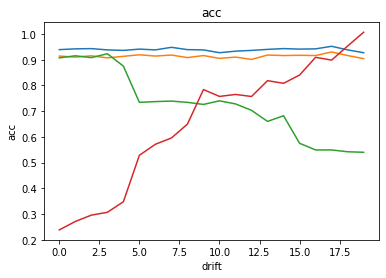

In [55]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(20), np.array(res['model_aggr']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(res['model_0to4']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(res['model_5to9']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(res['l2_dist']))
plt.title("acc")
plt.ylabel("acc")
plt.xlabel("drift")
plt.show()

In [56]:
res['req_rounds']

[1, 1, 2, 1, 1, 1, 1, 2, 2, 3, 4, 6, 4, 4, 5, 5, 6, 8, 6, 6]

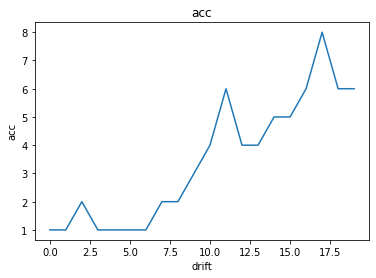

In [57]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(20), np.array(res['req_rounds']))
plt.title("acc")
plt.ylabel("acc")
plt.xlabel("drift")
plt.show()

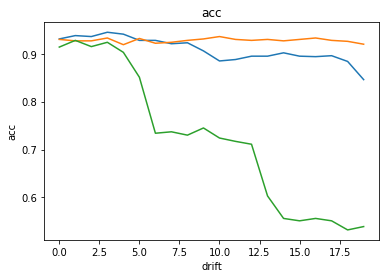

In [45]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(20), np.array(res['model_aggr']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(res['model_0to4']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(res['model_5to9']['test_0to4']['acc']))
plt.title("acc")
plt.ylabel("acc")
plt.xlabel("drift")
plt.show()

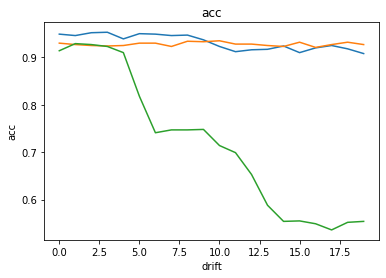

In [53]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(20), np.array(mult_res['model_aggr']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(mult_res['model_0to4']['test_0to4']['acc']))
plt.plot(np.arange(20), np.array(mult_res['model_5to9']['test_0to4']['acc']))
plt.title("acc")
plt.ylabel("acc")
plt.xlabel("drift")
plt.show()

In [39]:
def two_models_federated_learning(model, epochs, rounds, x_train, y_train, x_test, y_test, size):
    # result dict
    num_total_classes = 10 # todo np.unique(y_train)
    
    res = {}
    res['model_aggr'] = {}
    res['model_0to4'] = {}
    res['model_5to9'] = {}
    res['model_aggr']['test_all'] = {}
    res['model_aggr']['test_0to4'] = {}
    res['model_aggr']['test_5to9'] = {}
    
    res['model_0to4'] = copy.deepcopy(res['model_aggr'])
    res['model_5to9'] = copy.deepcopy(res['model_aggr'])
    
    # initialize models
    model1 = keras.models.clone_model(model)
    model2 = keras.models.clone_model(model)
    model1.set_weights(model.get_weights())
    model2.set_weights(model.get_weights())
    compile_model(model1)
    compile_model(model2)
    
    # get training dataset
    x1, y1 = utils.filter_data_by_labels(x_train, y_train, np.arange(5), size, 0, 123)
    x2, y2 = utils.filter_data_by_labels(x_train, y_train, np.arange(5)+5, size, 0, 1234)
    
    y1 = keras.utils.to_categorical(y1, num_total_classes)
    y2 = keras.utils.to_categorical(y2, num_total_classes)
    
    # get test dataset
    y_test_one_hot = keras.utils.to_categorical(y_test, num_total_classes)
    tx1, ty1 = utils.filter_data_by_labels(x_test, y_test, np.arange(5), 1000)
    tx2, ty2 = utils.filter_data_by_labels(x_test, y_test, np.arange(5)+5, 1000)
    ty1 = keras.utils.to_categorical(ty1, num_total_classes)
    ty2 = keras.utils.to_categorical(ty2, num_total_classes)
    
    for r in range(rounds):
        # fit
        fit_model_with_datasets(model1, epochs, x1, y1)
        fit_model_with_datasets(model2, epochs, x2, y2)
        
        #aggregate
        weights = [model1.get_weights(), model2.get_weights()]
        agg_weights = list()
        theta = 0.5
        for weights_list_tuple in zip(*weights):
            agg_weights.append(np.array([np.average(np.array(w), axis=0, weights=[1. - theta, theta]) for w in zip(*weights_list_tuple)]))
        aggr_model = keras.models.clone_model(model1)
        aggr_model.set_weights(agg_weights)
        compile_model(aggr_model)
        
        #test
        add_hist_to_dict(res['model_0to4']['test_all'],
                         model1.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_0to4'],
                         model1.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_0to4']['test_5to9'],
                         model1.evaluate(x=tx2, y=ty2, verbose=0))
        
        add_hist_to_dict(res['model_5to9']['test_all'],
                         model2.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_0to4'],
                         model2.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_5to9']['test_5to9'],
                         model2.evaluate(x=tx2, y=ty2, verbose=0))
        
        add_hist_to_dict(res['model_aggr']['test_all'],
                         aggr_model.evaluate(x=x_test, y=y_test_one_hot, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_0to4'],
                         aggr_model.evaluate(x=tx1, y=ty1, verbose=0))
        add_hist_to_dict(res['model_aggr']['test_5to9'],
                         aggr_model.evaluate(x=tx2, y=ty2, verbose=0))
        
        # update parameters
        model1.set_weights(agg_weights)
        model2.set_weights(agg_weights)
        
    return res

In [46]:
ROUNDS = 30

In [47]:
two_fl_res = two_models_federated_learning(init_model, 5, ROUNDS, x_train, y_train, x_test, y_test_orig, 600)

Training date and time : 
2020-09-10 10:20:48
Train on 600 samples
Epoch 1/5
600/600 [==============================] - 0s 202us/sample - loss: 0.0902 - acc: 0.1100
Epoch 2/5
600/600 [==============================] - 0s 41us/sample - loss: 0.0885 - acc: 0.2000
Epoch 3/5
600/600 [==============================] - 0s 40us/sample - loss: 0.0867 - acc: 0.3000
Epoch 4/5
600/600 [==============================] - 0s 40us/sample - loss: 0.0848 - acc: 0.3917
Epoch 5/5
600/600 [==============================] - 0s 43us/sample - loss: 0.0828 - acc: 0.4383
Training date and time : 
2020-09-10 10:20:49
Train on 600 samples
Epoch 1/5
600/600 [==============================] - 0s 175us/sample - loss: 0.0883 - acc: 0.1567
Epoch 2/5
600/600 [==============================] - 0s 40us/sample - loss: 0.0869 - acc: 0.2450
Epoch 3/5
600/600 [==============================] - 0s 36us/sample - loss: 0.0855 - acc: 0.3033
Epoch 4/5
600/600 [==============================] - 0s 36us/sample - loss: 0.0841 - acc

600/600 [==============================] - 0s 41us/sample - loss: 0.0317 - acc: 0.9117
Training date and time : 
2020-09-10 10:21:09
Train on 600 samples
Epoch 1/5
600/600 [==============================] - 0s 35us/sample - loss: 0.0631 - acc: 0.6350
Epoch 2/5
600/600 [==============================] - 0s 36us/sample - loss: 0.0555 - acc: 0.6700
Epoch 3/5
600/600 [==============================] - 0s 35us/sample - loss: 0.0513 - acc: 0.7167
Epoch 4/5
600/600 [==============================] - 0s 36us/sample - loss: 0.0481 - acc: 0.7417
Epoch 5/5
600/600 [==============================] - 0s 36us/sample - loss: 0.0453 - acc: 0.7900
Training date and time : 
2020-09-10 10:21:11
Train on 600 samples
Epoch 1/5
600/600 [==============================] - 0s 42us/sample - loss: 0.0449 - acc: 0.8800
Epoch 2/5
600/600 [==============================] - 0s 45us/sample - loss: 0.0364 - acc: 0.9017
Epoch 3/5
600/600 [==============================] - 0s 45us/sample - loss: 0.0318 - acc: 0.9117
Epo

600/600 [==============================] - 0s 43us/sample - loss: 0.0102 - acc: 0.9517
Epoch 4/5
600/600 [==============================] - 0s 51us/sample - loss: 0.0097 - acc: 0.9517
Epoch 5/5
600/600 [==============================] - 0s 47us/sample - loss: 0.0093 - acc: 0.9533
Training date and time : 
2020-09-10 10:21:54
Train on 600 samples
Epoch 1/5
600/600 [==============================] - 0s 45us/sample - loss: 0.0214 - acc: 0.9100
Epoch 2/5
600/600 [==============================] - 0s 41us/sample - loss: 0.0168 - acc: 0.9250
Epoch 3/5
600/600 [==============================] - 0s 43us/sample - loss: 0.0157 - acc: 0.9333
Epoch 4/5
600/600 [==============================] - 0s 43us/sample - loss: 0.0151 - acc: 0.9317
Epoch 5/5
600/600 [==============================] - 0s 43us/sample - loss: 0.0145 - acc: 0.9350
Training date and time : 
2020-09-10 10:21:58
Train on 600 samples
Epoch 1/5
600/600 [==============================] - 0s 42us/sample - loss: 0.0151 - acc: 0.9333
Epo

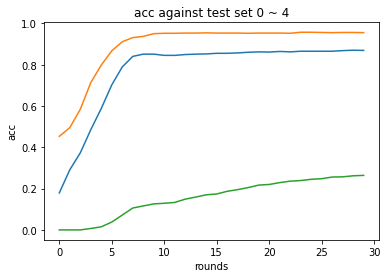

In [48]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(ROUNDS), np.array(two_fl_res['model_aggr']['test_0to4']['acc']))
plt.plot(np.arange(ROUNDS), np.array(two_fl_res['model_0to4']['test_0to4']['acc']))
plt.plot(np.arange(ROUNDS), np.array(two_fl_res['model_5to9']['test_0to4']['acc']))
plt.title("acc against test set 0 ~ 4")
plt.ylabel("acc")
plt.xlabel("rounds")
plt.show()

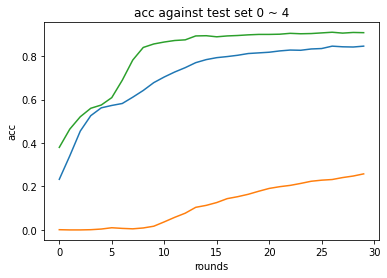

In [49]:
import matplotlib as plot
diff = list()
plt.plot(np.arange(ROUNDS), np.array(two_fl_res['model_aggr']['test_5to9']['acc']))
plt.plot(np.arange(ROUNDS), np.array(two_fl_res['model_0to4']['test_5to9']['acc']))
plt.plot(np.arange(ROUNDS), np.array(two_fl_res['model_5to9']['test_5to9']['acc']))
plt.title("acc against test set 0 ~ 4")
plt.ylabel("acc")
plt.xlabel("rounds")
plt.show()